In [1]:
import torch
from transformers import AutoTokenizer, EsmForMaskedLM
from transformers.models.esm.openfold_utils.protein import to_pdb, Protein as OFProtein
from transformers.models.esm.openfold_utils.feats import atom14_to_atom37

from Bio import SeqIO
import pandas as pd
import numpy as np
from time import perf_counter_ns
import matplotlib.pyplot as plt
import gc

SEQ_MAX_LEN = 8096

c:\Users\lgltan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### CUDA/Torch GPU Setup

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 4060 Ti


## Convert FASTA file to pd.DataFrame for easier processing

In [3]:
def fasta_to_dataframe(fasta_file):
    records = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):
        # Extract the ID after '>tr'
        id_info = seq_record.id.split('|')[1] # Adjust the index based on your FASTA file format
        sequence = str(seq_record.seq)
        
        # Generate a random index within the range of the sequence length
        random_index = np.random.randint(0, min(len(sequence), SEQ_MAX_LEN))
        # Replace the character at the random index with '<mask>'
        masked_sequence = sequence[:random_index] + '<mask>' + sequence[random_index+1:]
        
        records.append([id_info, sequence, masked_sequence])
    
    # Create a DataFrame from the records
    df = pd.DataFrame(records, columns=['ID', 'Sequence', 'Masked_Sequence'])
    return df

## Create Dataset

In [4]:
fasta_df = fasta_to_dataframe("human_protein_seq/uniprotkb_proteome_UP000005640.fasta")

In [5]:
fasta_df.head()

,ID,Sequence,Masked_Sequence
0,A0A075B6G3,MLWWEEVEDCYEREDVQKKTFTKWVNAQFSKFGKQHIENLFSDLQD...,MLWWEEVEDCYEREDVQKKTFTKWVNAQFSKFGKQHIENLFSDLQD...
1,A0A087WV00,MDAAGRGCHLLPLPAARGPARAPAAAAAAAASPPGPCSGAACAPSA...,MDAAGRGCHLLPLPAARGPARAPAAAAAAAASPPGPCSGAACAPSA...
2,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,MELSAEYLREKLQRDLEAEHVLPS<mask>GGVGQVRGETAASETQLGS
3,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,MGLEALVPLAMIVAIFLLLVDLMHRHQR<mask>AARYPPGPLPLP...
4,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...


## Preparing your model and tokenizer

Now we load our model and tokenizer. If using GPU, use `model.cuda()` to transfer the model to GPU.

In [6]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D")

In [7]:
# Ensure the model is in evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
print(f"Running test on {fasta_df.shape[0]} sequences.")

# set up accuracy & latency info - leave this in the same code block so that it resets each time
accuracy = []
latency = pd.DataFrame(columns=['start', 'tokenize', 'move_to_gpu', 'model', 'get_mask_id', "get_predicted", "cmp_sequences"])
sequence_length = []
ctr = 0

for id, fasta_row in fasta_df.iterrows():
    # comment this out for optimal speed
    ctr += 1
    if ctr % 100 == 0:
        percentage = "{:.2f}".format(ctr * 100 / fasta_df.shape[0])
        print(f"Processing... {percentage}%")
        # try to remove anything no longer needed on the GPU mem
        gc.collect()
    
    sequence_length.append(len(fasta_row["Sequence"]))
    latency_time_stamps = []
    
    # try to save as much memory as possible by reducing fragmentation
    torch.cuda.empty_cache()
    
    # load model to GPU
    model.to(device)

    # TIME LOG: start
    latency_time_stamps.append(perf_counter_ns())

    # Tokenize the input and move it to the correct device
    inputs = tokenizer(fasta_row["Masked_Sequence"], max_length=min(len(fasta_row["Masked_Sequence"]), SEQ_MAX_LEN), truncation=True, return_tensors='pt')
    
    # TIME LOG: tokenize
    latency_time_stamps.append(perf_counter_ns())
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # TIME LOG: move_to_gpu
    latency_time_stamps.append(perf_counter_ns())
    
    with torch.no_grad():
        logits = model(**inputs).logits
    
    # TIME LOG: model
    latency_time_stamps.append(perf_counter_ns())

    # Retrieve index of <mask>
    mask_token_index = (inputs["input_ids"] == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
    predicted_token_id = logits[0, mask_token_index].argmax(axis=-1).item()
    
    # TIME LOG: get_mask_id
    latency_time_stamps.append(perf_counter_ns())
    
    predicted_token = tokenizer.decode([predicted_token_id], skip_special_tokens=True)
    
    # TIME LOG: get_predicted
    latency_time_stamps.append(perf_counter_ns())
    
    unmasked_text = fasta_row['Sequence']
    masked_text = fasta_row["Masked_Sequence"]
    mask_position = masked_text.find('<mask>')
    actual_token = unmasked_text[mask_position]
    
    # TIME LOG: cmp_sequences
    latency_time_stamps.append(perf_counter_ns())

    if predicted_token == actual_token:
        accuracy.append(1)
    else:
        accuracy.append(0)
        
    latency.loc[len(latency.index)] = latency_time_stamps

Running test on 82485 sequences.
Processing... 0.0012
Processing... 0.0024
Processing... 0.0036
Processing... 0.0048
Processing... 0.0061
Processing... 0.0073
Processing... 0.0085
Processing... 0.0097
Processing... 0.0109
Processing... 0.0121
Processing... 0.0133
Processing... 0.0145
Processing... 0.0158
Processing... 0.0170
Processing... 0.0182
Processing... 0.0194
Processing... 0.0206
Processing... 0.0218
Processing... 0.0230
Processing... 0.0242
Processing... 0.0255
Processing... 0.0267
Processing... 0.0279
Processing... 0.0291
Processing... 0.0303
Processing... 0.0315
Processing... 0.0327
Processing... 0.0339
Processing... 0.0352
Processing... 0.0364
Processing... 0.0376
Processing... 0.0388
Processing... 0.0400
Processing... 0.0412
Processing... 0.0424
Processing... 0.0436
Processing... 0.0449
Processing... 0.0461
Processing... 0.0473
Processing... 0.0485
Processing... 0.0497
Processing... 0.0509
Processing... 0.0521
Processing... 0.0533
Processing... 0.0546
Processing... 0.0558
P

## Accuracy Log

In [9]:
print("Correctly Predicted: " + str(sum(accuracy)))
print("Total Runs: " + str(len(accuracy)))
print("Accuracy: " +  str(sum(accuracy)/len(accuracy)))

Correctly Predicted: 16587
Total Runs: 82485
Accuracy: 0.2010911074740862


## Latency/Time Log

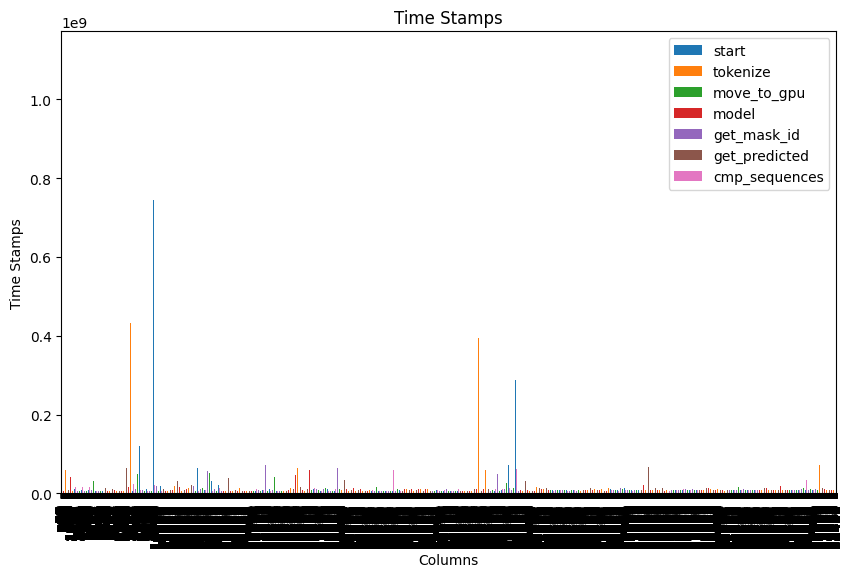

In [10]:
# drop headers
latency_diff = latency.diff().dropna()

latency_diff.plot(kind='bar', figsize=(10, 6))
plt.title('Time Stamps')
plt.xlabel('Columns')
plt.ylabel('Time Stamps')
plt.show()

KeyError: 'sequence_length'

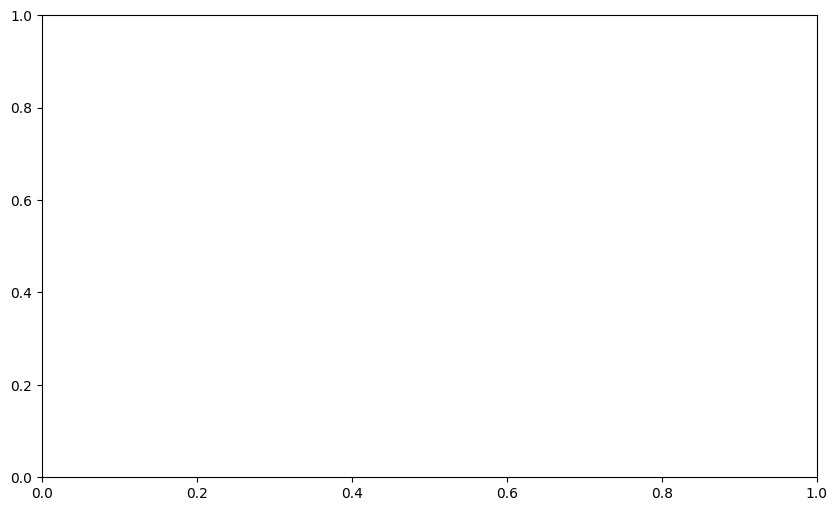

In [11]:
# Calculate total latency
total_latency = latency['cmp_sequences'] - latency['start']

# Merge the total latency with sequence_length DataFrame
lat_len_df = pd.DataFrame({ "Latency": total_latency, "Sequence_Length": sequence_length})

# Plotting sequence length vs total latency
lat_len_df.plot(x='sequence_length', y='total_latency', kind='scatter', figsize=(10, 6))
plt.title('Latency Graph of Sequence Length vs Total Latency')
plt.xlabel('Sequence Length')
plt.ylabel('Total Latency')
plt.show()